You can find this ipynb also in github, on\
https://github.com/Evanslearn/1st-Semester-AI-2023-2024-/tree/main/MachineLearning/Final%20Project

# Import Libraries

In [1]:
# Here we import the libraries we will use
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf

def install_agent_libraries():
  !pip install swig
  !pip install gymnasium[box2d]
  !pip install ray[rllib]
  !pip install renderlab
#install_agent_libraries()

In [2]:
# Check if GPU is enabled
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
import imageio.v3 as iio
import glob
from skimage import color
from skimage.exposure import rescale_intensity
from skimage.transform import resize

# 1. Express the moves (rock, scissors, paper) into (0, 1, 2) respectively

In [4]:
label_names = ['rock', 'scissors', 'paper']

In [5]:
def return_image_labels(action, labels_length):

  if action == 'rock':
    label = 0
  if action == 'scissors':
    label = 1
  if action == 'paper':
    label = 2

  # We create our array, which will be either all 0s, 1s, or 2s
  labels = np.zeros(labels_length) + label

  return labels

In [6]:
# This function returns all images from a folder, in grayscale
def return_all_images_grayscale(action):
  images = []

  # This is used to load the images
  for im_path in glob.glob(f"{action}/*.png"):
    im = iio.imread(im_path)

    # Resize image, to reduce dimensionality (from (200, 300) to -> (20, 30) )
    im = resize(im, (dim1, dim2))

    # Convert images to grayscale, to reduce dimensionality
    im = color.rgb2gray(im)
    im = rescale_intensity(im, out_range=(0, 255))

    images.append(im)

  images = np.array(images)
  images_labels = return_image_labels(action, len(images))

  return [images, images_labels]

In [7]:
dim1 = 20; dim2 = 30;

In [8]:
[images_rock, images_rock_labels] = return_all_images_grayscale('rock')
[images_scissors, images_scissors_labels] = return_all_images_grayscale('scissors')
[images_paper, images_paper_labels] = return_all_images_grayscale('paper')

# 2. Split the dataset into train-test: You can for each class select a ratio as test set (e.g. 20% of rock, 20% of scissors and 20% of paper) and use these to test your model/agent.

In [9]:
random_state = 0 # This is set to 0 (this way, we get the same results every time)
test_ratio = 0.2

In [10]:
# split into train and test sets
x_train_rock, x_test_rock, y_train_rock, y_test_rock = train_test_split(images_rock, images_rock_labels, test_size = test_ratio, random_state = random_state)
x_train_scissors, x_test_scissors, y_train_scissors, y_test_scissors = train_test_split(images_scissors, images_scissors_labels, test_size = test_ratio, random_state = random_state)
x_train_paper, x_test_paper, y_train_paper, y_test_paper = train_test_split(images_paper, images_paper_labels, test_size = test_ratio, random_state = random_state)

In [11]:
print(f'For sanity check, dimensions of \nall Rock images {images_rock.shape}, \ntrain set rock images {x_train_rock.shape}, \ntest set rock images: {x_test_rock.shape} ')

For sanity check, dimensions of 
all Rock images (726, 20, 30), 
train set rock images (580, 20, 30), 
test set rock images: (146, 20, 30) 


In [12]:
# Create the x_train, x_test, y_train, y_test, by contatenating the respective arrays
x_train = np.concatenate((x_train_rock, x_train_scissors, x_train_paper))
x_test = np.concatenate((x_test_rock, x_test_scissors, x_test_paper))

y_train = np.concatenate((y_train_rock, y_train_scissors, y_train_paper))
y_test = np.concatenate((y_test_rock, y_test_scissors, y_test_paper))

In [13]:
print(f'For sanity check, dimensions of \ntrain Rock images {x_train_rock.shape}, \ntrain set scissors images {x_train_scissors.shape}, \ntest set paper images: {x_train_paper.shape} ')
print(f'\nDimensions of x_train: {x_train.shape}')

For sanity check, dimensions of 
train Rock images (580, 20, 30), 
train set scissors images (600, 20, 30), 
test set paper images: (569, 20, 30) 

Dimensions of x_train: (1749, 20, 30)


In [14]:
# We use the reshape method to do the flattening.
# We simply designate that the number of rows should remain the same, and -1 as second argument takes care of the other dimensions
x_train_flatten = x_train.reshape(x_train.shape[0], -1)
x_test_flatten = x_test.reshape(x_test.shape[0], -1)
print(f'x_train.shape = {x_train.shape}. x_train_flatten.shape = {x_train_flatten.shape}')
print(f'x_test.shape = {x_test.shape}. x_train_flatten.shape = {x_test_flatten.shape}')

x_train.shape = (1749, 20, 30). x_train_flatten.shape = (1749, 600)
x_test.shape = (439, 20, 30). x_train_flatten.shape = (439, 600)


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # Define our scaler

x_train_flatten_norm = scaler.fit_transform(x_train_flatten)
x_test_flatten_norm = scaler.transform(x_test_flatten)

In [16]:
# Convert y_train, y_test to one-hot encodings
num_classes = 3 # classes (0, 1, 2) -> (rock, scissors, paper)

y_train_tf = tf.one_hot(y_train, depth=num_classes)
y_test_tf = tf.one_hot(y_test, depth=num_classes)
y_train_tf.shape, y_test_tf.shape

(TensorShape([1749, 3]), TensorShape([439, 3]))

In [17]:
# Reshape our arrays, to make them appropriate for CNN in tensorflow
# We set dim1 and dim2, when resizing the images during data reading
x_train_cnn = np.reshape(x_train_flatten_norm, (x_train_flatten_norm.shape[0], dim1,dim2,1))
x_test_cnn = np.reshape(x_test_flatten_norm, (x_test_flatten_norm.shape[0], dim1,dim2,1))

cnn = tf.keras.Sequential(name='my-cnn')
cnn.add(tf.keras.layers.Input((dim1,dim2,1), name='input_layer'))

In [18]:
num_conv_layers = 2
num_filters = 64
kernel_size = (5,5)
strides = (1,1)
mlp_num_hidden_layers = 2
mlp_units_per_layer = 128
activation = 'relu'
dropout_rate = 0.4

In [19]:
# CNN
for i in range(num_conv_layers):
  cnn.add(
      tf.keras.layers.Conv2D(
          filters=num_filters,
          kernel_size=kernel_size,
          strides=strides,
          activation=activation,
          name=f'conv_layer{i+1}'
      )
  )
  cnn.add(tf.keras.layers.Dropout(rate=dropout_rate , name=f'dropout_{i+1}'))
  cnn.add(tf.keras.layers.MaxPooling2D(name=f'maxpool_{i+1}'))

In [20]:
# Flattening
cnn.add(tf.keras.layers.Flatten())

In [21]:
# MLP
for i in range(mlp_num_hidden_layers):
  cnn.add(tf.keras.layers.Dense(units=mlp_units_per_layer, name=f'hidden_layer_{i+1}'))
cnn.add(tf.keras.layers.Dense(units=num_classes, activation='softmax', name='output_layer'))
cnn.summary()

Model: "my-cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 16, 26, 64)        1664      
                                                                 
 dropout_1 (Dropout)         (None, 16, 26, 64)        0         
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 13, 64)         0         
                                                                 
 conv_layer2 (Conv2D)        (None, 4, 9, 64)          102464    
                                                                 
 dropout_2 (Dropout)         (None, 4, 9, 64)          0         
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 2, 4, 64)          0         
                                                                 
 flatten (Flatten)           (None, 512)               0    

In [22]:
print(x_train_cnn.shape, y_train_tf.shape)

(1749, 20, 30, 1) (1749, 3)


In [23]:
learning_rate = 0.001
loss = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 16 # Initially I had tried 32
epochs = 50


start_time = time.perf_counter() # Get current time at start

cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=metrics)
history = cnn.fit(x_train_cnn, y_train_tf, batch_size=batch_size, epochs=epochs)#, validation_data=(x_test_cnn, y_test_tf))

end_time = time.perf_counter() # Get current time at end
cnn_neural_time = end_time - start_time # Substract the time at start and time at end, to find the total run time
print(f"Training Time: {cnn_neural_time:.4f}")

Epoch 1/50
110/110 [==============================] - 5s 28ms/step - loss: 0.6495 - accuracy: 0.7015
Epoch 2/50
110/110 [==============================] - 3s 27ms/step - loss: 0.2143 - accuracy: 0.9262
Epoch 3/50
110/110 [==============================] - 3s 27ms/step - loss: 0.1442 - accuracy: 0.9480
Epoch 4/50
110/110 [==============================] - 4s 35ms/step - loss: 0.1213 - accuracy: 0.9594
Epoch 5/50
110/110 [==============================] - 3s 27ms/step - loss: 0.0790 - accuracy: 0.9760
Epoch 6/50
110/110 [==============================] - 3s 27ms/step - loss: 0.0753 - accuracy: 0.9726
Epoch 7/50
110/110 [==============================] - 3s 26ms/step - loss: 0.0796 - accuracy: 0.9731
Epoch 8/50
110/110 [==============================] - 4s 35ms/step - loss: 0.0592 - accuracy: 0.9828
Epoch 9/50
110/110 [==============================] - 3s 27ms/step - loss: 0.0383 - accuracy: 0.9886
Epoch 10/50
110/110 [==============================] - 3s 27ms/step - loss: 0.0314 - accura

In [24]:
# From the training, we have the statistics stored in object history:
print(history.history.keys())

losses = history.history['loss']
accuracies = history.history['accuracy']
#val_losses = history.history['val_loss']
#val_accuracies = history.history['val_accuracy']

dict_keys(['loss', 'accuracy'])


<ipython-input-25-f3f8114bb9b4>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
<ipython-input-25-f3f8114bb9b4>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2)


Text(0.5, 1.0, 'Accuracy vs epoch')

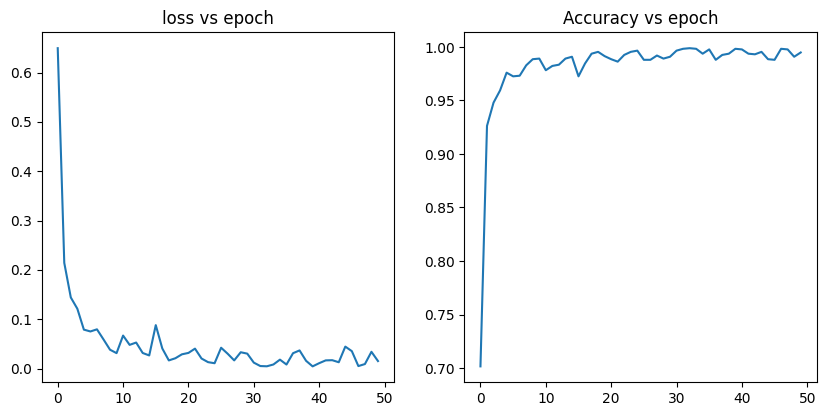

In [25]:
# Plot the results of our training, for each epoch
f, axs = plt.subplots(1, 2, figsize=(10, 10))

plt.subplot(2,2,1)
plt.plot(losses)
plt.title('loss vs epoch')

plt.subplot(2,2,2)
plt.plot(accuracies)
plt.title('Accuracy vs epoch')

#plt.subplot(2,2,3)
#plt.plot(val_losses)
#plt.title('loss(val) vs epoch')

#plt.subplot(2,2,4)
#plt.plot(val_accuracies)
#plt.title('Accuracy(val) vs epoch')

# 3. Select Image: Select a radom image frm the 2100 (which corresponds to move 0, or 1, or 2)

In [26]:
import random

In [27]:
# since the method returns [a, b], I have set [1, length], and then deduct 1
random_integer = random.randint(1, len(x_test)) - 1

random_image = x_test[random_integer]
random_image_label = y_test[random_integer]
random_image_label_string = label_names[int(random_image_label)]

# 4. Preprocess Image: Process the image:

*  a. wih probability $p_1$ apply Vertical flip

In [28]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [29]:
def flip_vertically(image, p1 = 0.5):

  random_float = random.random()

  if random_float >= p1:
    image = np.flip(image, axis = 0) # We flip vertically

  return image

random_image = flip_vertically(random_image)

*  b. with probability $p_2$ apply Horizontal flip



In [30]:
def flip_horizontally(image, p2 = 0.5):

  random_float = random.random()

  if random_float >= p2:
    image = np.flip(image, axis = 1) # We flip horizontally

  return image

random_image = flip_horizontally(random_image)

*  c. Add noise with $\mu = 0$, $\sigma = 255\cdot 0.05$. If you normalize the image, adjust standard deviation accordingly.

In [31]:
def add_noise(image, mu = 0, sigma = 255 * 0.05):

  # if we have normalized, then normalize sigma as well
  if sigma == 255 * 0.05:
    if np.max(image) <= 1:
      sigma = sigma/255
  image = image + np.random.normal(mu, sigma, image.shape) # Add the gaussian noise
  return image

random_image = add_noise(random_image)

*  d. You can apply any other method Image Processing you want, so that you can make the game harder (if you want).

In [32]:
from scipy.ndimage import rotate

In [33]:
# I will also add a 45 degrees rotation, with probability 0.5
def rotate_angle(image, p3 = 0.5, angle = 45):

  random_float = random.random()

  if random_float >= p3:
    image = rotate(image, angle=45, reshape=False)
  return image

random_image = rotate_angle(random_image)

# 5. Apply: Send the image to your agent

In [34]:
# COnvert the image to tf tensor
img_array = tf.keras.utils.img_to_array(random_image)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# Calculate predictions
predictions = cnn.predict(img_array)
score = tf.nn.softmax(predictions[0])
predicted_enemy_action = label_names[np.argmax(predictions[0])]

print(
    "This image most likely belongs to {} = {} with a {:.2f} percent confidence."
    .format(np.argmax(predictions[0]), predicted_enemy_action, 100 * np.max(score))
)

1/1 [==============================] - 0s 175ms/step
This image most likely belongs to 0 = rock with a 57.61 percent confidence.


# 6. The agent reads the image and selects the optimal action

In [35]:
def select_optimal_action(enemy_action):

  if enemy_action == 'rock':
    optimal_action = 'paper'
  if enemy_action == 'scissors':
    optimal_action = 'rock'
  if enemy_action == 'paper':
    optimal_action = 'scissors'

  return optimal_action

In [36]:
optimal_action = select_optimal_action(enemy_action = predicted_enemy_action)
print("Enemy predicted action \n\t{} \nso our model played \n\t{}".format(predicted_enemy_action, optimal_action))


Enemy predicted action 
	rock 
so our model played 
	paper


# 7. The goal is maximizing gain. So, you will need to plot the agent's gain (You can store the total gain for every round and plot it at the end of the game)

In [37]:
def return_gain_step(predicted_enemy_action, actual_enemy_action):

  # If we predicted the enemy action correctly, then we win since we play 2nd. Gain for win is 2
  if predicted_enemy_action == actual_enemy_action:
    gain = 2
  else:
    # If we played the same as the enemy, then it's a draw. Gain for draw is 1
    if( select_optimal_action(predicted_enemy_action) == actual_enemy_action ):
      gain = 1
    else:
      gain = 0

  return gain

In [38]:
gain_for_one_step = return_gain_step(predicted_enemy_action = predicted_enemy_action, actual_enemy_action = random_image_label_string)
print(
    "The model played one round. \nactual_enemy_action = {}. \npredicted_enemy_action = {}. \nSo, the gain is = {}"
    .format(predicted_enemy_action, random_image_label_string, gain_for_one_step)
)

The model played one round. 
actual_enemy_action = rock. 
predicted_enemy_action = rock. 
So, the gain is = 2


In [39]:
# i will now try calculating the total gain for the whole test set
N = len(x_test)

gain_total = np.zeros(N)
gain_cum = np.zeros(N)
index_help = range(0,N)

for i in range(0, N):

  # get image from test set
  random_image = x_test[i]
  random_image_label = y_test[i]
  random_image_label_string = label_names[int(random_image_label)]

  # apply preprocessing to the image
  random_image = flip_vertically(random_image)
  random_image = flip_horizontally(random_image)
  random_image = add_noise(random_image)
  random_image = rotate_angle(random_image)

  if i >=1:
    gain_cum[i] = gain_cum[i-1] + gain_for_one_step
  gain_total[i] = gain_for_one_step


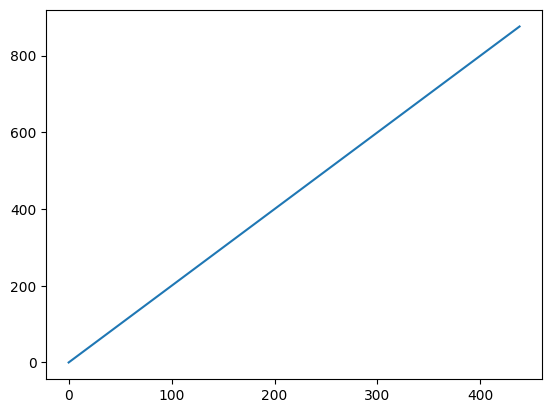

In [40]:
plt.plot(index_help, gain_cum)

# 8. As end goal, try the accuracy of the agent (or model) on images outside of the dataset, e.g. from the intenret or your own, which you must rescale to the same size. For example, you can try the action it will output for the attached image

# 5. Create an agent. Use summart to print the policy model. Describe the created Neural Network.

In [41]:
def import_agent():
  import gymnasium as gym
  import ray
  from ray.rllib.algorithms.ppo import PPOConfig
#import_agent()

In [42]:
def agent_definition_01():
  ray.shutdown()
  ray.init()

  config = PPOConfig()
  config.use_critic = True # Use Actor-Critic Architecture
  config.use_gae = True # Use Generalzed Advantage Updates
  config.lambda_ = 0.95 # Lambda Learning parameter
  config.user_kl_loss = True # Use KL-Penalty in addition to e-Clipping
  config.sgd_minibatch_size = 32 # Batch Size
  config.num_sgd_iter = 30 # Epochs
  config.shuffle_sequences = True # Whether to shffle episode sequences
  config.vf_loss_coeff = 0.5 # Value Function loss Regularization
  config.entropy_coeff = 0.001 # Entropy Regularization coefficient for Exploration
  config.clip_param = 0.2 # e-Clipping parameter

  agent = config.environment("LunarLander-v2").framework(framework='tf').build()
  agent.get_policy().model.base_model.summary(expand_nested=True)
#agent_definition_01()

# 6. Create a train loop to train the agent

In [43]:
def agent_train():
  train_iterations = 100
  average_rewards_per_iteration = []

  for i in range(train_iterations):
    log = agent.train()
    average_rewards = log['sampler_results']['episode_reward_mean']
    average_rewards_per_iteration.append(average_rewards)

    print(f'Iteration {i + 1}, Average Rewards: {average_rewards}')


  plt.plot(average_rewards_per_iteration)
  plt.title('PPO LunarLander-v2')
  plt.xlabel('Iterations')
  plt.ylabel('Average Rewards')
  plt.show()
#agent_train()

# 7. Use the library renderlab to "render" the gym environmonet in colab, to see how the trained agent plays.

In [44]:
#import renderlab as rl

In [45]:
def agent_run():
  env = gym.make("LunarLander-v2", render_mode = "rgb_array")
  env = rl.RenderFrame(env, "./output")

  observation, info = env.reset()

  while True:
    action = env.action_space.sample()
    observation,reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
      break

  env.play()
#agent_run()